In [1]:
# Imports (numpy, pandas, matplotlib, seaborn imported automatically)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config
from scipy.stats import poisson, lognorm, norm
from random import shuffle

In [2]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)

eth_client.get_eth_last_price()

{'ethbtc': '0.05967',
 'ethbtc_timestamp': '1654591492',
 'ethusd': '1772.01',
 'ethusd_timestamp': '1654591491'}

# Nexus Tokenomics Investigation

## Set-up & Parameters

In [3]:
nxm_supply_now = 6_793_923
nxm_supply = nxm_supply_now
act_cover_now = 167_837
act_cover = act_cover_now
capital_factor = 4.8
cap_pool_now = 153_329
cap_pool = cap_pool_now

def mcr():
    return act_cover/capital_factor

def mcrp(capital):
    return capital/mcr()

def book_value(capital):
    return capital/nxm_supply

print(f'mcrp: {mcrp(cap_pool)}, book value: {book_value(cap_pool)}')

mcrp: 4.38508314614775, book value: 0.02256855133624564


In [4]:
book_value_usd = book_value(cap_pool)*float(eth_client.get_eth_last_price()['ethusd'])
book_value_usd

39.99169865334064

### Dynamic Current Assets

DCA = Size of capital pool X-days in the future, i.e. current Capital Pool minus everything in the Exit Queue

In [47]:
model_days = 366
bond_length = 30
exit_period = 30
base_exit_days = 122
mcrp_max_days = 122
queue_max_days = 122

exit_array = np.zeros((1, model_days + base_exit_days + queue_max_days + mcrp_max_days + exit_period))
entry_array = np.zeros((1, model_days+bond_length))

In [48]:
# create function that calculates the size of the exit queue in NXM or ETH
# current book value * notional number of NXM in the exit queue (maximum of each row)
def exit_queue_size(denom='eth'):
    nxm_in_queue = np.sum(np.amax(exit_array, axis=1))
    if denom == 'nxm':
        return nxm_in_queue
    return book_value(cap_pool) * np.sum(np.amax(exit_array, axis=1))

In [49]:
exit_queue_size()

0.0

In [50]:
def dca():
    return cap_pool - exit_queue_size()

In [51]:
dca()

185135.55391465852

### wNXM price feed

In [10]:
url = 'https://api.coingecko.com/api/v3/simple/price'
params = {
        'ids':'wrapped-nxm',
        'vs_currencies': 'eth'
        }
wnxm_price_now = requests.get(url, params=params).json()['wrapped-nxm']['eth']
wnxm_price = wnxm_price_now
wnxm_price_usd = wnxm_price * float(eth_client.get_eth_last_price()['ethusd'])
wnxm_price_usd

17.5900906368

## New Tokenomics - Capital Entry

### Bond Bonus Formula

In [11]:
# creating shape of discount vs. mcr_perc below 100%
def bond_bonus(mcr_perc):
    return 0.02 * (1 - np.exp(-30 * (1-mcr_perc)))

MCR% at 0.0:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.01:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.02:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.03:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.04:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.05:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.06:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.07:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.08:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.09:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.1:          Monthly interest at 2.0%,          Annual interest at 26.82%
MCR% at 0.11:          Monthly interest at 2.0%,          Annual interest at 2

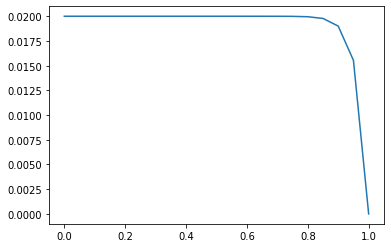

In [12]:
perc_range_below_100 = np.linspace(0, 1, 21)
bond_bonus_range = bond_bonus(perc_range_below_100)
for i in np.linspace(0, 1, 101):
    print(f'MCR% at {round(i, 2)}:\
          Monthly interest at {round(bond_bonus(i)*100, 2)}%,\
          Annual interest at {round(((1+bond_bonus(i))**12 - 1)*100, 2)}%')
plt.plot(perc_range_below_100, bond_bonus_range);

### Mechanism for Single Entry with Bond

In [13]:
# this cell creates the numpy row vector with the redeemed NXM bond_length days from now.
# Will only apply when MCR < 1, otherwise instantaneous exchange of ETH for NXM at wNXM price

# length of simulation
model_days = 366
bond_length = 30 # can play around with this
current_day = 0

def single_bond(eth):
    # create array of zeros representing whole modelling period
    row_vec = np.zeros(model_days + bond_length)
    
    # what could someone get now at wnxm price or book value (incl. exit queue)
    nxm_now = eth/wnxm_price
    
    # create array of entry-size NXM possibilities over 30 days (and cap at book value)
#     nxm_obtained_array = np.linspace(nxm_now, nxm_now*(1+bond_bonus(mcrp(dca()))), bond_length+1)
#     nxm_obtained_array[eth/nxm_obtained_array < book_value(dca())] = eth/book_value(dca())
    
    # pick at which point the user will claim their tokens - simplification
#     actual_entry_delay = np.random.randint(bond_length + 1)

    ## Simpler version - be locked for the duration of the bond and receive tokens at end of lock
    # nxm obtained is lowest of nxm obtained at wnxm price + bond interest & nxm obtained at book value 
    nxm_obtained = min(eth/book_value(dca()), nxm_now*(1+max(0, bond_bonus(mcrp(dca())))))
    
    # replace the relevant time period in question in the array of zeros with the entry NXM obtained
#     row_vec[current_day:current_day + actual_entry_delay] = nxm_obtained_array[actual_entry_delay] # replace with array
    row_vec[current_day + bond_length] = nxm_obtained

    return row_vec

In [14]:
single_bond(2)

array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
       88.6188914,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    

## New Version - Capital Exit

### Weighted average days on covers 

In [ ]:
### TODO: Provide live feed instead of just pulling in .csv
# https://github.com/rchen8/nexus-mutual-tracker

Treat Weighted Average Days of cover expiry as fixed - unlikely to be able to calculate this on-chain

In [15]:
# bring in csv
active_covers_expiration = pd.read_csv('../raw_data/active_cover_amount_by_expiration_date.csv')
# rename columns
active_covers_expiration.columns = ['exp_time', 'USD', 'ETH']
# convert expiry time from string to datetime
active_covers_expiration['exp_time'] = pd.to_datetime(active_covers_expiration['exp_time'])
# create a 'days remaining column by subtracting today's date in datetime format
active_covers_expiration['days_remaining'] = active_covers_expiration['exp_time']-pd.Timestamp.now().normalize()
# create an integer minutes remaining column by dividing by a timedelta minute object
active_covers_expiration['minutes_remaining'] = active_covers_expiration['days_remaining']/np.timedelta64(1, 'm')

#calculate weighted average minutes remaining based on cover amount
wavg_minutes = ((active_covers_expiration['ETH']*active_covers_expiration['minutes_remaining'])
                /active_covers_expiration['ETH'].sum()).sum()

# calculate 
wavg_days = wavg_minutes/(24*60)
wavg_days

63.60394299022312

In [16]:
2*wavg_days
# use this as proxy for base level

127.20788598044624

### Mechanism for Single Exit Below 100%

In [39]:
model_days = 366
current_day = 0

# Exit mechanism is dynamic based on 1) mcrp and/or 2) size of exit queue
# 122 days as baseline below 100%
base_exit_days = 122

# option to exit active for certain number of days
minimum_exit_period = 14
exit_period = 30

# 122 days added linearly from 100% down to 80%
mcrp_max_days = 122
def mcrp_exit_days():
    mcrp_trigger = 1
    mcrp_threshold = 0.8
    return min(1, max(0, (mcrp_trigger - mcrp(dca())) / (mcrp_trigger - mcrp_threshold))) * mcrp_max_days

# 122 days added linearly from 10% of NXM in exit queue to 20% of NXM in exit queue
queue_max_days = 122
def queue_exit_days():
    queue_trigger = 0.1
    queue_threshold = 0.2
    queue_ratio = exit_queue_size('nxm') / nxm_supply
    return min(1, max(0, (queue_ratio - queue_trigger) / (queue_threshold - queue_trigger))) * queue_max_days

# combine the moving day target to 100% with a quadratic function to 100%
# output the row vector reflecting the possibilities of exit
# including 0 for first 14 days the period after getting to 100% and instant 100% after 14 days if mcrp > 1
def exit_ratios():
    
    row_vec = np.zeros(model_days + base_exit_days + mcrp_max_days + queue_max_days + exit_period)

    # if mcr% > 100%, user has option to exit 14 days from now at full book value for 30 days 
    if mcrp(dca()) > 1:
        ratio_array = np.ones(exit_period)
        row_vec[current_day + minimum_exit_period:current_day + minimum_exit_period + exit_period] = ratio_array
    
    else: # below 100% mcr
        # determine number of days required to get to 100%
        days = base_exit_days + mcrp_exit_days() + queue_exit_days()
        # create array of exit possibilities
        ratio_array = np.minimum(np.fromfunction(lambda x: (x/days)**2, (days+exit_period,)), 1)
        # replace first 14 days with zero
        ratio_array[:minimum_exit_period] = 0
        # replace array of zeros with ratio array in right position
        row_vec[current_day:current_day+days+exit_period] = ratio_array
    
    # return vector of exit possibilities
    return row_vec

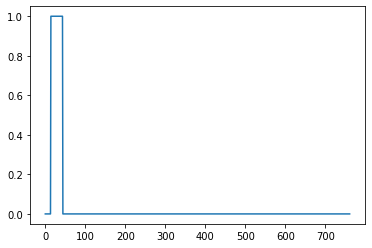

In [40]:
plt.plot(exit_ratios())

In [19]:
# single_delayed_exit function converts desired ETH amount into nxm at book value (based on current capital)
# in practice the users will choose NXM amount they want to sell
# nxm value row will represent the amount that the user gets at book value
# in practice user will always burn the full amount of NXM
def single_exit(eth):
    # calculate amount of nxm that user wants to sell from eth they want to obtain
    nxm = eth/book_value(cap_pool)
    
    # multiply nxm value into row vector
    return exit_ratios() * nxm

In [20]:
# test out various fixed probabilities at different lengths:
1 - (1-0.04)**30

0.7061423567692946

### Account for Different Exit Scenarios

## Nexus System Development

Every day, the following happens:

- Users **enter** the system by buying NXM from the mutual **at wNXM price** (or with some discount)
    - expect this number to be higher when mcrp < 1 because there is a discount to wNXM depending on vesting period
    - some will want to buy wNXM for ease, some will want to buy NXM for use on the platform
- Users **exit** from the system **at book value**
    - noone if wNXM price > book value, as first, NXM would be converted to wNXM and sold on the open market. This will drive the price down to book value if more users want to exit.
    - If wNXM price <= book value, expect wNXM buys and exits through book value, driving wNXM price up to book value (with a slight time value discount, assume 5% per year)
- Change in wNXM price
    - if below book value, price gets driven up towards *book value less time discount*
    - if above book value, could go up if mutual doing well, could go down if mutual perceived to be doing badly (e.g. after a big claim)
- Funds come in to capital pool separately through premiums & investment
    - steady stream of income from premiums, possibly increasing, test decrease as well
    - steady stream of income from investments, say 5% on 30% of capital pool to reflect current position
- Funds exit the capital pool through claims
    - rare, but large events
    - possible hits to wNXM price if above book value
- Change in NXM supply
    - entries and exits through capital mechanism (even if NXM created in future)
    - cover buys still create some?
    - some irregular governance rewards
    - burned through cover buys in NXM
    - upon claim, burns of stakers' NXM
- Update active cover amount for tracking mcr requirement
- Update exit queue size
- Update dca & mcrp as a result

In [37]:
# parameters of various developments
# length of simulation
model_days = 366

# ENTERING AND EXITING THE SYSTEM

# assume there are, on average, some same base distribution of entries and exits each day
# modelled by a poisson distribution
lambda_entries = 10
lambda_exits = 10

# lognormal distribution of size of entries & exits in ETH
# parameterised to have  values be small < 1 ETH, the median value to be ~1 ETH,
# upper quartile around 4-5 ETH and the occasional multi-million buy
sale_shape = 2
sale_loc = 0
sale_scale = 1

# allow a 30 day period for exit option
exit_period = 30
# minimum exit period of 14 days to avoid rush once claims comes in
minimum_exit_period = 14

# parameters for moving number of days to get to 100% of book value
base_exit_days = 122
mcrp_max_days = 122
queue_max_days = 122

# there is some exit probability each day there is a non-zero value
# assume that there's a 4% chance of exit at full book value each day that option is available
# this 4% probability scales down linearly with the ratio of book value that is available
# (so e.g. if the user can get 50% of book value, the probability of exiting is 2% )
p_exit_full = 0.04
def p_exit(idx, nxm):
    row = exit_array[idx]
    ratio = nxm/np.max(row)
    return p_exit_full * ratio
# cost of exit option in nxm
option_cost = 0.1

# COVER AMOUNT

# normal distribution of change in cover amount
cover_amount_mean = 0
cover_amount_stdev = 0.07

# PREMIUM INCOME

# lognormal distribution of daily premium income
# parameterised to have median value of a handful of ETH,
# upper quartile around 10 ETH and the occasional multi-million $ day
premium_shape = 2
premium_loc = 0.02
premium_scale = 3

# CLAIM OCCURENCES

# claim frequency
claim_prob = 0.03

# lognormal distribution of claim size
# parameterised to have values of at least 1 ETH, the median value to be ~9 ETH,
# upper quartile around 30 ETH and the occasional multi-million payout
claim_shape = 2
claim_loc = 1
claim_scale = 15

# assume premium was 2.6% of claim size (for assessor NXM rewards)
claim_ass_reward = 0.026 * 0.2

# WNXM PRICE MOVEMENTS

# Random Movement
# normal distribution of change in wnxm price, before any adjustments we assume for what happens
wnxm_drift = 0   # assume there's no long-term drift from ETH
wnxm_diffusion = 0.0655 # st.dev. of historic returns since summer 2020

# Closing to Book Value
# assume that people ascribe a 5% time value to the fixed 122 day exit period 
wnxm_discount_to_book = 0.05
# assume that price moves 2% with every 60 ETH (based on liquidity at Bancor), equivalent to 0.033% per 1 ETH
gap_eth_sale = 60
def gap_wnxm_move(gap_eth_sale):
    return gap_eth_sale / 3000

In [71]:
### ---MAIN SIMULATION LOOP--- ###

# start at day 0
current_day = 0
nxm_supply = nxm_supply_now
act_cover = act_cover_now
capital_factor = 4.8
cap_pool = cap_pool_now
wnxm_price = wnxm_price_now

# set randomised number of base daily entries and exits
daily_entries = poisson.rvs(lambda_entries, size=model_days)
daily_exits = poisson.rvs(lambda_exits, size=model_days)

# create empty exit array of ETH liabilities to users and entry array of NXM claims via bonds
exit_array = np.zeros((1, model_days + base_exit_days + mcrp_max_days + queue_max_days + exit_period))
entry_array = np.zeros((1, model_days + bond_length))

# set cumulative premium and claims to 0
cum_premiums = 0
cum_claims = 0

# create tracking lists for metrics we want to track with opening values
mcr_prediction = [mcr()]
cap_pool_prediction = [cap_pool]
mcrp_prediction = [mcrp(dca())]
wnxm_prediction = [wnxm_price]
nxm_supply_prediction = [nxm_supply]
book_value_prediction = [book_value(dca())]
exit_queue_eth_prediction = [exit_queue_size()]
exit_queue_nxm_prediction = [exit_queue_size(denom='nxm')]
dca_prediction = [dca()]
premium_prediction = [0]
act_cover_prediction = [act_cover]
claim_prediction = [0]
num_exits_prediction = [0]

for i in range(model_days):
    
    # create list of events that happen today and shuffle them to be random
    events_today = []
    events_today.extend(['entry']*daily_entries[i])
    events_today.extend(['exit']*daily_exits[i])
    events_today.extend(['wnxm_shift'])
    events_today.extend(['premium_income'])
    events_today.extend(['claim_check'])
    events_today.extend(['cover_amount_change'])
    #events_today.extend(['bond_entries'])
    events_today.extend(['delayed_exits'])
    shuffle(events_today)
    
    # loop through the day's events
    for event in events_today:
        
        #-----SINGLE ENTRIES-----#
        if event == 'entry':
            # no entries if wnxm price is below book
            if wnxm_price < book_value(dca()):
                continue
            
            # draw entry size from lognormal distribution
            eth_size = lognorm.rvs(s=sale_shape, loc=sale_loc, scale=sale_scale)
            
            # eth enters the capital pool
            cap_pool += eth_size
            
            # NXM Supply changes
            # instantaneous @ wnxm price if mcrp >= 1
            if mcrp(dca()) >= 1:
                nxm_supply += eth_size / wnxm_price
                
            # add to queued entry array if mcrp < 1 & increase NXM supply immediately
            else:
                bond_row = single_bond(eth_size)
                entry_array = np.vstack((entry_array, bond_row))
                nxm_supply += sum(bond_row)
        
        #-----SINGLE EXITS & GAP CLOSING-----#
        elif event == 'exit':
            # no exits if wnxm price is above book
            if wnxm_price > book_value(dca()):
                continue
            
            # CLOSE WNXM TO BOOK GAP, IF RELEVANT #
            while wnxm_price < book_value(dca())*(1-wnxm_discount_to_book):
                # set assumed individual arbitrage sale size
                eth_size = gap_eth_sale
                
                # if mcr% > 100%,
                # check whether size reduces mcrp below 1 & turn eth_size into maximum possible
                # such that mcrp doesn't go below 1 
                if mcrp(dca()) > 1:
                    if mcrp(dca() - gap_eth_sale) <= 1:
                        eth_size = dca() - mcr()
                
#                     # reduce nxm supply and remove ETH from capital pool
#                     nxm_supply -= eth_size/wnxm_price  # book_value(dca())
#                     cap_pool -= eth_size

                # add row of potential NXM exits to exit array
                exit_array = np.vstack((exit_array, single_exit(eth=eth_size)))
#                     # burn 10% of NXM size
#                     nxm_supply -= gap_eth_sale/book_value(dca()) * option_cost
                
                # move wNXM price
                wnxm_price *= 1 + gap_wnxm_move(eth_size)

            
            # SINGLE EXIT #
            # draw exit size from lognormal distribution
            eth_size = lognorm.rvs(s=sale_shape, loc=sale_loc, scale=sale_scale)
            
                # if mcr% > 100%,
                # check whether size reduces mcrp below 1 & turn eth_size into maximum possible
                # such that mcrp doesn't go below 1 
            if mcrp(dca()) > 1:
                if mcrp(dca() - gap_eth_sale) <= 1:
                    eth_size = dca() - mcr()

#             # reduce nxm supply and remove ETH from capital pool
#             nxm_supply -= eth_size/wnxm_price # book_value(dca())
#             cap_pool -= eth_size
             
#             # add to exit queue if mcrp <= 1
#             else:
            
            # add single exit to the exit array
            exit_array = np.vstack((exit_array, single_exit(eth=eth_size)))
            
#                 # burn 10% of NXM size
#                 nxm_supply -= eth_size/wnxm_price * option_cost # book_value(dca()) 
        
        #-----WNXM RANDOM MARKET MOVEMENT-----#
        elif event == 'wnxm_shift':
            # percentage change according to pre-defined normal distribution
            wnxm_price *= 1 + norm.rvs(loc=wnxm_drift, scale=wnxm_diffusion)
        
        #-----PREMIUM INCOME TO POOL-----#
        elif event == 'premium_income':
            # work out daily premium size in ETH assuming a lognormal distribution
            daily_premiums = lognorm.rvs(s=premium_shape, loc=premium_loc, scale=premium_scale)
            # 50% of premium size gets transformed to NXM and paid out to stakers
            # entry is at wNXM price
            cap_pool += daily_premiums
            nxm_supply += 0.5 * daily_premiums/wnxm_price
            cum_premiums += daily_premiums
        
        #-----DAILY CHANGE IN COVER AMOUNT-----#
        elif event == 'cover_amount_change':
            # random fluctuation based on normal distribution
            act_cover *= 1 + norm.rvs(loc=cover_amount_mean, scale=cover_amount_stdev)
            
        #-----CLAIM EVENT-----#
        elif event == 'claim_check':
            # check if claims occur
            if np.random.random() > claim_prob:
                continue
            # if a claim has occured, determine size
            claim_size = lognorm.rvs(s=claim_shape, loc=claim_loc, scale=claim_scale)
            # burn 50% of nxm at wnxm price and remove claims amount from capital pool
            nxm_supply -= 0.5 * claim_size/wnxm_price
            cap_pool -= claim_size
            cum_claims += claim_size
            # NB: could introduce wNXM shock if claim is over a certain size?
        
        #-----BOND ENTRIES-----#
        ### commented out because makes more sense to add NXM to supply immediately
#         elif event == 'bond_entries':
#             # sum up entries on current day and add to NXM supply
#             nxm_supply += np.sum(entry_array[:, current_day])
        
        #-----DELAYED EXITS-----#
        elif event == 'delayed_exits':
            # don't do this for first days within minimum exit period
            if current_day < minimum_exit_period:
                continue
            
            removal_rows = []
            # slice exit array to current day & loop through entries
            current_exits = exit_array[:, current_day]
            for idx, number_nxm in np.ndenumerate(current_exits):
                # if value is non-zero, check whether user chooses to exit
                if number_nxm != 0:
                    # successful exit
                    if np.random.random() < p_exit(idx, number_nxm):
                        # burn full NXM value of row
                        nxm_supply -= np.max(exit_array[idx[0]])
                        # remove eth value from capital pool
                        cap_pool -= number_nxm * book_value(cap_pool)
                        # add row to removal_rows
                        removal_rows.append(idx[0])
                        
                # check whether the option hasn't been exercised - row should be removed & option cost burnt
                elif exit_array[idx, current_day-1] != 0:
                    nxm_supply -= option_cost*exit_array[idx[0], current_day-1]
                    # add row to removal rows
                    removal_rows.append(idx[0])
                    
                        
            # remove rows from exit array:
            exit_array = np.delete(exit_array, removal_rows, axis=0)

                    
    mcr_prediction.append(mcr())
    cap_pool_prediction.append(cap_pool)
    exit_queue_eth_prediction.append(exit_queue_size())
    exit_queue_nxm_prediction.append(exit_queue_size(denom='nxm'))
    dca_prediction.append(dca())
    book_value_prediction.append(book_value(dca()))
    mcrp_prediction.append(mcrp(dca()))
    wnxm_prediction.append(wnxm_price)
    nxm_supply_prediction.append(nxm_supply)
    premium_prediction.append(cum_premiums)
    claim_prediction.append(cum_claims)
    act_cover_prediction.append(act_cover)
    num_exits_prediction.append(exit_array.shape[0])
    
    current_day += 1

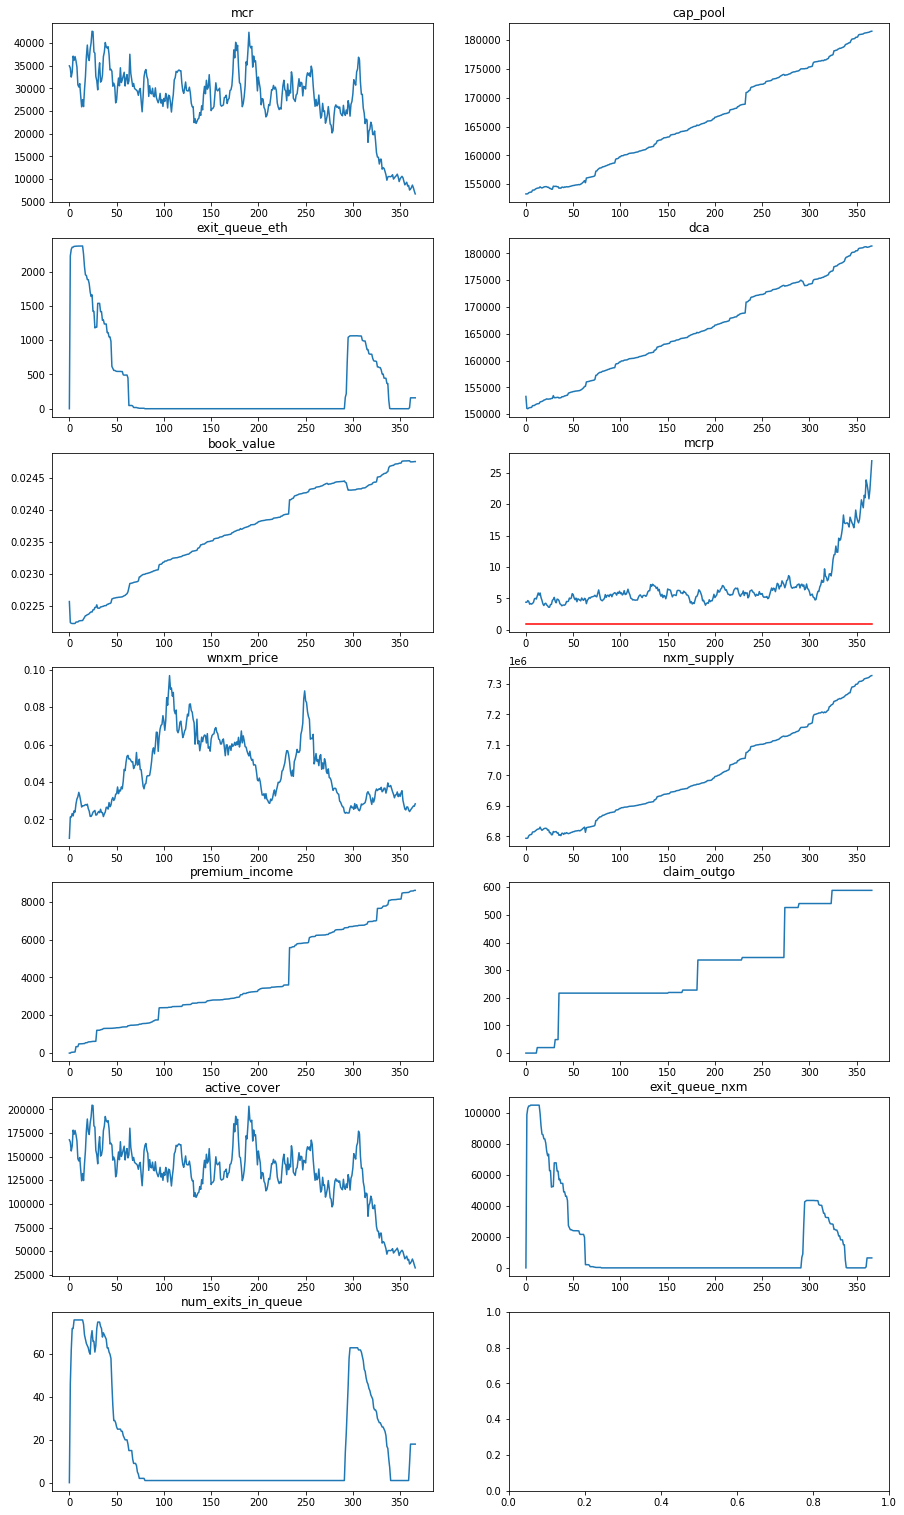

In [72]:
#-----GRAPHS-----#
# Destructuring initialization
fig, axs = plt.subplots(7, 2, figsize=(15,27)) # axs is a (7,2) nd-array

# Subplot 1
axs[0, 0].plot(range(model_days+1), mcr_prediction)
axs[0, 0].set_title('mcr')
# Subplot 2
axs[0, 1].plot(range(model_days+1), cap_pool_prediction)
axs[0, 1].set_title('cap_pool')
# Subplot 3
axs[1, 0].plot(range(model_days+1), exit_queue_eth_prediction)
axs[1, 0].set_title('exit_queue_eth')
# Subplot 4
axs[1, 1].plot(range(model_days+1), dca_prediction)
axs[1, 1].set_title('dca')
# Subplot 5
axs[2, 0].plot(range(model_days+1), book_value_prediction)
axs[2, 0].set_title('book_value')
# Subplot 6
axs[2, 1].plot(range(model_days+1), mcrp_prediction)
axs[2, 1].plot(range(model_days+1), np.ones(model_days+1), color='red')
axs[2, 1].set_title('mcrp')
# Subplot 7
axs[3, 0].plot(range(model_days+1), wnxm_prediction)
axs[3, 0].set_title('wnxm_price')
# Subplot 8
axs[3, 1].plot(range(model_days+1), nxm_supply_prediction)
axs[3, 1].set_title('nxm_supply')
# Subplot 9
axs[4, 0].plot(range(model_days+1), premium_prediction)
axs[4, 0].set_title('premium_income')
# Subplot 10
axs[4, 1].plot(range(model_days+1), claim_prediction)
axs[4, 1].set_title('claim_outgo')
# Subplot 11
axs[5, 0].plot(range(model_days+1), act_cover_prediction)
axs[5, 0].set_title('active_cover');
# Subplot 12
axs[5, 1].plot(range(model_days+1), exit_queue_nxm_prediction)
axs[5, 1].set_title('exit_queue_nxm');
# Subplot 13
axs[6, 0].plot(range(model_days+1), num_exits_prediction)
axs[6, 0].set_title('num_exits_in_queue');

In [70]:
for idx, number_nxm in np.ndenumerate(current_exits):
    print(idx, number_nxm)

(0,) 0.0
(1,) 0.6901771143971709
(2,) 36.20677116010054
(3,) 1.651294218281776
(4,) 1.7939855113867569
(5,) 18.262964913626696
(6,) 0.7505877305563005
(7,) 106.8278797325841
(8,) 37.282022454878316
(9,) 1.3986396632683595


## Initial Reverse Dutch Auction Mechanism

At launch, exit price = wnxm price

Price slowly increases, but starts dropping down once people try to exit through the mechanism

Keeps going up, stops at book value.

Incentive not to wait longer - some people may end up exiting in front of you and drive down the price.
What if you believe it'll go up eventually anyway...